<a href="https://colab.research.google.com/github/jfpIE16/SL_II_Tareas/blob/master/Tarea_I_SLII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Learning II
## Tarea 1: Clustering y Detección de Anomalias
José Fernando Pérez Pérez
---
josefernando.perez@galileo.edu


In [1]:
# Importamos las librerías necesarias
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from copy import deepcopy
plt.ion()

Definimos los datos de entrenamiento

In [2]:
df = pd.read_excel('/content/drive/My Drive/Estaturas.xlsx', sheet_name=0, index_col=False)
df.head()

,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


Visualización del conjunto de datos de entrenamiento

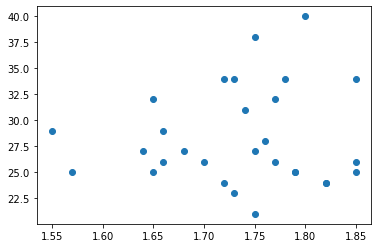

In [3]:
plt.scatter(df["Estatura(metros)"], df["Edad(años)"])
plt.show()

Definimos los datos de prueba

In [4]:
df_test = pd.read_excel('/content/drive/My Drive/Estaturas.xlsx', sheet_name=1, index_col=False)
df_test.head()

,Estatura(metros),Edad(años)
0,1.82,25
1,1.80,27
2,1.60,31
3,1.60,35
4,1.82,30


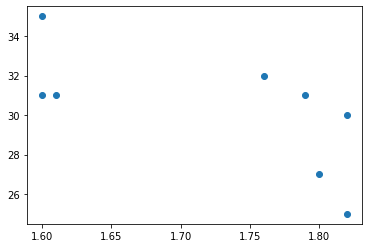

In [5]:
plt.scatter(df_test["Estatura(metros)"], df_test["Edad(años)"])
plt.show()

In [6]:
X = df[["Estatura(metros)", "Edad(años)"]].values
X_test = df_test[["Estatura(metros)", "Edad(años)"]].values

# K-Means

Se crea una clase para la implementación del algoritmo KMeans, donde también se implementa el cálculo de la distorsión para utilizar el método del codo y elegir heuristicamente el valor de **k**.

---

In [7]:
class Kmeans:
  def __init__(self, k):
    self.k = k
    self.centroids = None
    self.distortion = 0.0

  def clusters_centroids(self, X):
    return X[np.random.randint(X.shape[0], size=self.k)]

  def compute_distances(self, X, centroid):
    return np.linalg.norm(X - centroid, axis=1)

  def fit(self, X):
    self.centroids = self.clusters_centroids(X)
    clusters = np.zeros(X.shape[0], dtype=np.float64)
    distances = np.zeros([X.shape[0], self.k], dtype=np.float64)
    for i in range(300):
      for i, c in enumerate(self.centroids):
        distances[:, i] = self.compute_distances(c, X)

      clusters = np.argmin(distances, axis=1)

      for c in range(self.k):
        self.centroids[c] = np.mean(X[clusters == c], 0)

      self.distortion = sum(np.min(cdist(X, self.centroids, 'euclidean'), 
                                   axis=1)) / X.shape[0]

  def get_clusters(self, X):
    distances = np.zeros([X.shape[0], self.k], dtype=np.float64)
    for i, c in enumerate(self.centroids):
        distances[:, i] = self.compute_distances(c, X)

    return np.argmin(distances, axis=1)

Gráfica de las distorsiones. Se puede observar que según el método del codo se tiene un valor *optimo* para **k=2**.

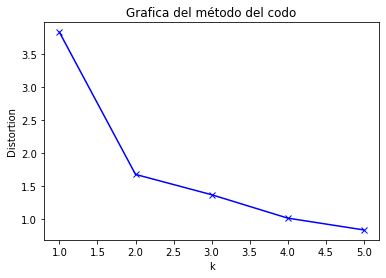

In [11]:
#Ejecutamos 5 experimentos con k distinto para poder utilizar el metodo del codo
distortions = []
K = range(1,6)
for k in K:
  model = Kmeans(k)
  model.fit(X)
  distortions.append(model.distortion)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Grafica del método del codo')
plt.show()

Obtenemos los centroides para el valor de k=2.

In [9]:
kmean_model = Kmeans(k=2)
kmean_model.fit(X)
centroids = kmean_model.centroids
clusters = kmean_model.get_clusters(X)

Visualizamos los datos obtenidos

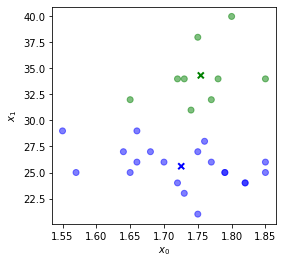

In [10]:
group_colors = ['blue', 'green']
colors = [group_colors[j] for j in clusters]

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X[:,0], X[:,1], color=colors, alpha=0.5)
ax.scatter(centroids[:,0], centroids[:,1], color=group_colors, marker='x', lw=2)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$');

Aplicamos el modelo al set de pruebas y graficamos el resultado.

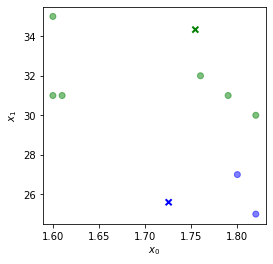

In [12]:
clusters_test = kmean_model.get_clusters(X_test)
group_colors = ['blue', 'green']
colors = [group_colors[j] for j in clusters_test]

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X_test[:,0], X_test[:,1], color=colors, alpha=0.5)
ax.scatter(centroids[:,0], centroids[:,1], color=group_colors, marker='x', lw=2)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$');


# Gaussian Mixture Models

Se utilizara el algoritmo GMM que viene con el paquete scikit-learn.

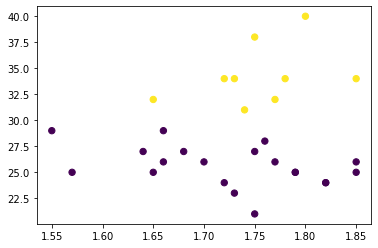

In [17]:
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Clustering con datos de prueba y modelo GMM.

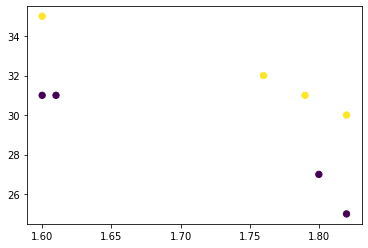

In [20]:
labels = gmm.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=labels, s=40, cmap='viridis');

Mostrar la matriz de probabilidades para los datos de prueba.

In [19]:
probs = gmm.predict_proba(X_test)
print(probs[:5].round(3))

[[1.    0.   ]
 [0.989 0.011]
 [0.627 0.373]
 [0.002 0.998]
 [0.182 0.818]]


# Conclusiones



*   Para la distribución de datos dados el método del codo me parece adecuado, como se observa en la gráfica es evidente una separación entre los clusters y si se agregaran mas quedarían muy juntos.
*   A diferencia de KMeans el modelo GMM es capaz de implementar clusters no necesariamente circulares sino también elipticos y diagonales lo que hace más flexible para trabajar con distribuciones complejas.
*   Al aplicar ambos modelos al conjunto de pruebas hay 2 observaciones que difieren en ambos enfoques, podría tratarse de una anomalía. Pienso que sería útil definir un "Threshold" de distancia o probabilidad que nos ayude a la detección de anomalías en la clasificación de los clusters.
*   Considero que el conjunto de datos se puede clasificar en dos clusters distintos.

